**Setup**

For quicker model training

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

/Users/mmesoma/Desktop/FaceReg/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Install dependencies

In [3]:
%pip install tensorflow==2.15.1 opencv-python matplotlib

You should consider upgrading via the '/Users/mmesoma/Desktop/FaceReg/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

Import dependencies

In [16]:
#Import tensor flow dependencies - Functional API

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization
import tensorflow as tf


#Model: Lets you build and train a neural network.
#Layer: The base class for all Keras layers.
#Conv2D: Adds convolutional layers to extract image features.
#Dense: Fully connected layer for making decisions.
#MaxPooling2D: Reduces image size while keeping key features.
#Input: Defines the input shape of the model.
#Flatten: Turns multi-dimensional data into a flat vector.


Set GPU growth

In [6]:
#Avoiding out of memory errors for memory consumption
gpus=tf.config.experimental.list_physical_devices('GPU')

# Enable memory growth for each GPU, so TensorFlow uses memory as needed instead of pre-allocating all at once
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Create folder structures

In [7]:
#Setting paths for directories

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
#Create directories

#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

Moving lfw pictures

In [9]:
##https://vis-www.cs.umass.edu/lfw/

# Import required libraries
import os

# Uncompress the tgz dataset
!tar -xf lfw.tgz

# Ensure the negative path directory exists
os.makedirs(NEG_PATH, exist_ok=True)

# Move LFW images to the negative repository
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    if os.path.isdir(dir_path):  # Check if it's a directory
        for file in os.listdir(dir_path):  # List files within the subdirectory
            EX_PATH = os.path.join(dir_path, file)  # Current file path
            NEW_PATH = os.path.join(NEG_PATH, file)  # New file path
            os.replace(EX_PATH, NEW_PATH)  # Move the file


Collecting anchor and positive images

In [11]:
#import uuid to generate unique image names
import uuid

#Establish connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Define the crop ratio (e.g., 0.5 means 50% of the frame's size)
    crop_ratio = 0.5

    # Get the dimensions of the frame
    height, width, _ = frame.shape

    # Calculate the crop dimensions based on the ratio
    crop_height = 250
    crop_width = 250

    # Calculate the center of the frame
    center_y, center_x = height // 2, width // 2

    # Define the coordinates for the crop here it'll be 250x250
    start_y = max(0, center_y - crop_height // 2)
    start_x = max(0, center_x - crop_width // 2)
    end_y = start_y + crop_height
    end_x = start_x + crop_width

    frame = frame[start_y:end_y, start_x:end_x]

    #Collect anchor 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Create unique file path
        imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write anchor image
        cv2.imwrite(imgname,frame)

    #Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #Create unique file path
        imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write POSITIVE image
        cv2.imwrite(imgname,frame)


    #Show image back to screen 
    cv2.imshow('Image Collection', frame)

    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#release webcam
cap.release()

#close the image show frame
cv2.destroyAllWindows()

2025-01-09 07:25:23.390 Python[41524:26282970] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


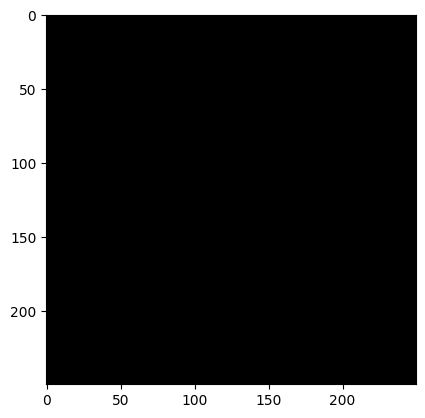

In [12]:
#frame = frame[120:120+250, 200:200+250, :]  # Extract the image slice
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.show()

In [13]:
#Getting our imaage directories as datasets

anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)


In [14]:
dir_test = anchor.as_numpy_iterator() #testing the uuid 

In [15]:
print(dir_test.next())

b'data/anchor/84e36a9a-c2cf-11ef-a0d0-a63d57b1cd1f.jpg'


PREPROCESS IMAGES

In [23]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    # Add basic image augmentation for better model generalization
    img = tf.image.random_flip_left_right(img)  # Random horizontal flip
    img = tf.image.random_brightness(img, 0.1)   # Slight brightness adjustment
    img = tf.image.resize(img, (100, 100))
    # Handle potential numerical instabilities
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [24]:
img=preprocess('data/anchor/8dd3a430-c2cf-11ef-a0d0-a63d57b1cd1f.jpg')

In [25]:
img.numpy().max()

0.9267157

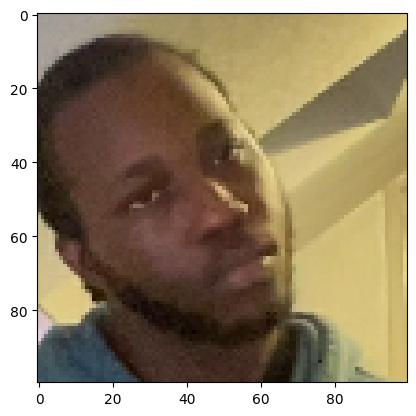

In [26]:
plt.imshow(img)

In [27]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine both positive and negative pairs into a single dataset with a mix of matching and non-matching pairs
data = positives.concatenate(negatives) 

In [28]:
data

#The first string is our file path to the specific image, second string is the path to either the positive or neggative image
#last value determines whether its +ve or -ve for verification

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
sample=data.as_numpy_iterator()

In [30]:
eg=sample.next()

BUILD, TRAIN AND TEST PARTITION 

In [88]:
#Function to preprcess the input and validation images as twins
def preprocess_twins(input_img, validation_img, label):
    try:
        print("Input types:", type(input_img), type(validation_img), type(label))
        print("Input image values:", input_img)
        
        def process_single_image(img):
            # If the image is already a tensor, we need to handle it differently
            if isinstance(img, tf.Tensor):
                # If it's already a preprocessed image tensor
                if img.dtype == tf.float32:
                    return tf.image.resize(img,(100,100))
                # If it's a string tensor (filepath)
                elif img.dtype == tf.string:
                    img = tf.io.read_file(img)
                    img = tf.io.decode_jpeg(img, channels=3)
                    img = tf.cast(img, tf.float32) / 255.0
                    img = tf.image.resize(img, (100, 100))
                    return img
            return None
        
        processed_input = process_single_image(input_img)
        processed_validation = process_single_image(validation_img)
        
        return processed_input, processed_validation, label
    except Exception as e:
        print(f"Error processing images: {str(e)}")
        raise

In [66]:
# Check the first element of the dataset
sample = next(iter(data))
print("Sample structure:", [type(x) for x in sample])
print("First element shape/type:", tf.shape(sample[0]), sample[0].dtype)

Sample structure: [<class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>]
First element shape/type: tf.Tensor([ 32 250 250   3], shape=(4,), dtype=int32) <dtype: 'float32'>


In [67]:
res = preprocess_twins(*eg)  # * collecting the eg values from the register

Input types: <class 'bytes'> <class 'bytes'> <class 'numpy.float32'>
Input image values: b'data/anchor/8b488a3c-c2cf-11ef-a0d0-a63d57b1cd1f.jpg'


In [36]:
res[1]

In [37]:
res[2]

1.0

Build dataloader pipeline

In [89]:
def build_data_pipeline(data, batch_size=32):
    # First, we'll make sure our images are all the right size (100x100)
    data = data.map(preprocess_twins, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Cache is still good - keeps our preprocessed data in memory
    data = data.cache()
    
    # Shuffle before batching to ensure good mixing
    data = data.shuffle(1000)
    
    # Add drop_remainder=True to ensure all batches have the same size
    data = data.batch(batch_size, drop_remainder=True)
    
    # Prefetch is still good for performance
    data = data.prefetch(tf.data.AUTOTUNE)
    
    return data

In [ ]:
# Create the training and validation datasets
BATCH_SIZE = 32
data = build_data_pipeline(data, BATCH_SIZE)

Input types: <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'> <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Input image values: Tensor("args_0:0", shape=(None, None, None, 250, 250, 3), dtype=float32)
Error processing images: 'images' must have either 3 or 4 dimensions.


ValueError: in user code:

    File "/var/folders/l6/7n445dpj3bj189pnvn43qhrm0000gn/T/ipykernel_41524/1673661509.py", line 12, in process_single_image  *
        return tf.image.resize(img,(100,100))

    ValueError: 'images' must have either 3 or 4 dimensions.


In [39]:
round(len(data)*0.3)

4

Training partition

In [83]:
train_size = round(len(data) * 0.7)    # Calculates split point
train_data = data.take(train_size)     # Takes 70% of data
val_data = data.skip(train_size)      # Creates test set from remaining 30%

In [91]:
# Debug function to check dataset shapes
def inspect_dataset(dataset, name="Dataset"):
    print(f"\nInspecting {name}:")
    try:
        for batch_idx, batch in enumerate(dataset.take(1)):
            print(f"Batch {batch_idx + 1}:")
            print(f"Input shape: {batch[0].shape}")
            print(f"Validation shape: {batch[1].shape}")
            print(f"Label shape: {batch[2].shape}")
    except Exception as e:
        print(f"Error while inspecting dataset: {str(e)}")
        print("Dataset element spec:", dataset.element_spec)

In [92]:
# Check both datasets
inspect_dataset(train_data, "Training Data")
inspect_dataset(val_data, "Testing Data")


Inspecting Training Data:

Inspecting Testing Data:


In [84]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>

In [42]:
train_sample = train_data.as_numpy_iterator()

In [43]:
train_sample =train_sample.next()

In [44]:
len(train_sample[0])

9

Testing partition


In [71]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16) 
test_data = test_data.prefetch(8)

MODEL ENGINEERING

In [72]:

#https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf  Siememse networks paper

#Builds embedding layer

def make_embedding():
    inp=Input(shape=(100,100,3), name='input_image')

    #First block 
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

    #Second block
    c2 = Conv2D(128, (3,3), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

    #Third block 
    c3 = Conv2D(128, (7,7), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)

    #Fouth block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [73]:
embedding = make_embedding()

In [74]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 batch_normalization_1 (Bat  (None, 91, 91, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 128)       0 

Build distance layer

In [75]:
class L1Dist(Layer):

    #Init method for inheritance
    def __init__(self, **kwargs):
        super().__init__()

    #Des the similarity calculation 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) + 1e-6

In [50]:
l1 = L1Dist()

Make Siamese model

In [51]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #Combine siamese distance components
    siamise_layer = L1Dist()
    siamise_layer._name = 'distance'
    distances = siamise_layer(embedding(input_image), embedding(validation_image))

    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [76]:
siamese_model = make_siamese_model()

In [77]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 2763936   ['input_img[0][0]',           
                                                          0          'validation_img[0][0]']      
                                                                                     

TRAINING OUR MODEL

Setup loss function and optimizer

In [54]:
loss_function = tf.losses.BinaryCrossentropy()

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9
)

In [55]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule) #learning rate @ 0.0001 initially then gradually reduces

Make a ckeckpoint 

In [56]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build train step function

In [57]:
test_batch = train_data.as_numpy_iterator()

In [58]:
batch1 = test_batch.next()

In [59]:
batch1[2]

array([[0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.

In [60]:
@tf.function
def train_step(batch):
    
    #Record all of our operations
    with tf.GradientTape() as tape:
        #get anchor and positive or negative
        X=batch[:2]

        #get label
        Y=batch[2]

        #frward pass
        yhat = siamese_model(X, training= True)

        #calculate loss
        loss= loss_function(Y, yhat)
    print(loss)

    #calculate gradient
    gradient = tape.gradient(loss, siamese_model.trainable_variables)
    # Clip gradients to prevent exploding gradients
    clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradient]
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(clipped_gradients, siamese_model.trainable_variables))



    return loss

Build training loop

In [61]:
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1,EPOCHS+1): 
        print('\n Epoch{}/{}'.format(epoch, EPOCHS)) #prints 1 out of number of epochs
        progbar = tf.keras.utils.Progbar(len(data)) #progress bar, if i wrapped this up in a model class no need but i want more control

        # Keep track of losses for each epoch
        epoch_loss = tf.keras.metrics.Mean()

        #loop through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)  # Make sure train_step returns a scalar loss value
            epoch_loss.update_state(loss)
            progbar.update(idx+1, values=[('loss', epoch_loss.result())])

        #save checkpoints
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [62]:
EPOCHS = 50

In [79]:
# Check data shape
for batch in train_data.take(1):
    print("Input shape:", batch[0].shape)
    print("Validation shape:", batch[1].shape)
    print("Label shape:", batch[2].shape)
    break

# Check model input shape
print("\nModel input shape:")
for layer in siamese_model.layers:
    if isinstance(layer, tf.keras.layers.InputLayer):
        print(f"{layer.name}: {layer.input_shape}")

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [32,250,250,3] and element 8 had shape [16,250,250,3]. [Op:IteratorGetNext] name: 

In [78]:
# Clear any existing weights and start fresh
siamese_model = make_siamese_model()  # Your model creation function
# Train with the new improvements
train(train_data, EPOCHS)


 Epoch1/50


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [32,250,250,3] and element 7 had shape [16,250,250,3]. [Op:IteratorGetNext] name: 

EVALUATE MODEL